In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio
import numpy as np

# Settings
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"

**Change the renderer if you are running the notebook in an interactive environment**

In [2]:
pio.renderers.default = "png"

Reading the dataset

In [3]:
#reading the file with an attempt to authomaticly parse the dates
df = pd.read_csv('data/houses.csv', parse_dates=['sale_date'], date_format='%d/%m/%Y')
df.head(10).style.format(precision=1)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_date,price
0,7129300520,3.0,1.0,1180.0,5650.0,1.0,nan,0.0,3,7,1180.0,0.0,1955,0.0,98178,47.5,-122.3,1340.0,5650.0,2014-10-13,221900.0
1,6414100192,3.0,2.2,2570.0,7242.0,2.0,0.0,0.0,3,7,2170.0,400.0,1951,19910.0,98125,47.7,-122.3,1690.0,7639.0,2014-12-09,538000.0
2,5631500400,2.0,1.0,770.0,10000.0,1.0,0.0,0.0,3,6,770.0,0.0,1933,nan,98028,47.7,-122.2,2720.0,8062.0,2015-02-25,180000.0
3,2487200875,4.0,3.0,1960.0,5000.0,1.0,0.0,0.0,5,7,1050.0,910.0,1965,0.0,98136,47.5,-122.4,1360.0,5000.0,2014-12-09,604000.0
4,1954400510,3.0,2.0,1680.0,8080.0,1.0,0.0,0.0,3,8,1680.0,0.0,1987,0.0,98074,47.6,-122.0,1800.0,7503.0,2015-02-18,510000.0
5,7237550310,4.0,4.5,5420.0,101930.0,1.0,0.0,0.0,3,11,3890.0,1530.0,2001,0.0,98053,47.7,-122.0,4760.0,101930.0,2014-05-12,1230000.0
6,1321400060,3.0,2.2,1715.0,6819.0,2.0,0.0,0.0,3,7,1715.0,nan,1995,0.0,98003,47.3,-122.3,2238.0,6819.0,2014-06-27,257500.0
7,2008000270,3.0,1.5,1060.0,9711.0,1.0,0.0,nan,3,7,1060.0,0.0,1963,0.0,98198,47.4,-122.3,1650.0,9711.0,2015-01-15,291850.0
8,2414600126,3.0,1.0,1780.0,7470.0,1.0,0.0,0.0,3,7,1050.0,730.0,1960,0.0,98146,47.5,-122.3,1780.0,8113.0,2015-04-15,229500.0
9,3793500160,3.0,2.5,1890.0,6560.0,2.0,0.0,0.0,3,7,1890.0,0.0,2003,0.0,98038,47.4,-122.0,2390.0,7570.0,2015-03-12,323000.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21145 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17749 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  float64
 18  sqft_l

Takeaways: 
* ✔️ The column names are already in a good format
* ✔️ The dates were parsed correctly
* ❗️ `yr_renovated` has missing values. Which is expected because not every house needs renovation; also, small scale cosmetic works may not be documented at all. The values should be reformatted (e.g. $19910.0$ -> $1991$) and imputed.
> Assumption: BOTH the missing values AND zeroes in the renovation year column `yr_renovated`mean the house has **never** been renovated
* ❗️ `waterfront` has missing values which should be imputed.
> Hypothesis: missing values are equivalent to 0 (or NO waterfront in sight). Can be verified with geoplots.
* ❗️ `sqft_basement` has missing values which should be imputed. According to the table documentation, area of basement is already implicitly contained in `sqft_living`. So we can simply recalculate the whole column as a difference between `sqft_living`and `sqft_above`. 

*For convenience of the European Analyst, we will also convert the Imperial units to the Metric system*

### Imputing

`yr_renovated`

In [5]:
# Get the column yr_renovated into the good format:

df.yr_renovated.unique()

array([    0., 19910.,    nan, 20020., 20100., 19920., 20130., 19940.,
       19780., 20050., 20030., 19840., 19540., 20140., 20110., 19830.,
       19450., 19900., 19880., 19770., 19810., 19950., 20000., 19990.,
       19980., 19700., 19890., 20040., 19860., 20070., 19870., 20060.,
       19850., 20010., 19800., 19710., 19790., 19970., 19500., 19690.,
       19480., 20090., 20150., 19740., 20080., 19680., 20120., 19630.,
       19510., 19620., 19530., 19930., 19960., 19550., 19820., 19560.,
       19400., 19760., 19460., 19750., 19640., 19730., 19570., 19590.,
       19600., 19670., 19650., 19340., 19720., 19440., 19580.])

In [6]:
df['yr_renovated'].fillna(0, inplace=True) 
df['yr_renovated'] = (df.yr_renovated / 10).astype(int)
df['yr_renovated'].replace(0, np.nan, inplace=True) # this is the only way that works!

df.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_date,price
0,7129300520,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,3,7,...,0.0,1955,NaN,98178,47.5112,-122.257,1340.0,5650.0,2014-10-13,221900.0
1,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3,7,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690.0,7639.0,2014-12-09,538000.0
2,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3,6,...,0.0,1933,NaN,98028,47.7379,-122.233,2720.0,8062.0,2015-02-25,180000.0
3,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5,7,...,910.0,1965,NaN,98136,47.5208,-122.393,1360.0,5000.0,2014-12-09,604000.0
4,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3,8,...,0.0,1987,NaN,98074,47.6168,-122.045,1800.0,7503.0,2015-02-18,510000.0


`waterfront`

In [7]:
df.waterfront.unique()

array([nan,  0.,  1.])

In [8]:
df['waterfront'] = df.waterfront.fillna(0).astype('int0') # converting to the approprite type as well

`sqft_basement`

Checking if the values are alright: What area of the basement is in the rows which do NOT add up to the `sqft_living` value?

In [9]:
# It would be a problem if there were any values (but None)
df[(df.sqft_living - df.sqft_above != df.sqft_basement)].sqft_basement.unique() 

array([nan])

Looks good, so we are simply recalculating the column:

In [10]:
df.eval('sqft_basement = sqft_living - sqft_above', inplace=True)

# Adding a column that is easier to analyse
df.eval('basement_share = sqft_basement / sqft_living', inplace=True)

Finally, let's transform feet to meters: 

In [11]:
cols = df.columns

cols_area = [c for c in cols if 'sqft' in c]
cols_area_new = [c.replace('sqft', 'm2') for c in cols_area]

df[cols_area] = df[cols_area] / 10.764
df.rename(columns={old: new for old, new in zip(cols_area, cols_area_new)}, inplace=True)
df.head()

,id,bedrooms,bathrooms,m2_living,m2_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,m2_living15,m2_lot15,sale_date,price,basement_share
0,7129300520,3.0,1.00,109.624675,524.897808,1.0,0,0.0,3,7,...,1955,NaN,98178,47.5112,-122.257,124.489038,524.897808,2014-10-13,221900.0,0.000000
1,6414100192,3.0,2.25,238.758826,672.798216,2.0,0,0.0,3,7,...,1951,1991.0,98125,47.7210,-122.319,157.004831,709.680416,2014-12-09,538000.0,0.155642
2,5631500400,2.0,1.00,71.534745,929.022668,1.0,0,0.0,3,6,...,1933,NaN,98028,47.7379,-122.233,252.694166,748.978075,2015-02-25,180000.0,0.000000
3,2487200875,4.0,3.00,182.088443,464.511334,1.0,0,0.0,5,7,...,1965,NaN,98136,47.5208,-122.393,126.347083,464.511334,2014-12-09,604000.0,0.464286
4,1954400510,3.0,2.00,156.075808,750.650316,1.0,0,0.0,3,8,...,1987,NaN,98074,47.6168,-122.045,167.224080,697.045708,2015-02-18,510000.0,0.000000


### Feature engineering

Let's add a few columns for our convenience:
* `age`: age of the building. Easier to read than the `yr_built`
* `yrs_since_renovation`: years since the last documented renovation
* `p_per_m2`: price per square meter, a common metric of the property value.

In [12]:
CURRENT_YEAR = 2015
df = df.assign(age = CURRENT_YEAR - df.yr_built,
          yrs_since_renovation = CURRENT_YEAR - df.yr_renovated,
          p_per_m2 = np.round(df.price / df.m2_living, 1) # digits beyond the decimal are not relevant
          )
df.head()

,id,bedrooms,bathrooms,m2_living,m2_lot,floors,waterfront,view,condition,grade,...,lat,long,m2_living15,m2_lot15,sale_date,price,basement_share,age,yrs_since_renovation,p_per_m2
0,7129300520,3.0,1.00,109.624675,524.897808,1.0,0,0.0,3,7,...,47.5112,-122.257,124.489038,524.897808,2014-10-13,221900.0,0.000000,60,NaN,2024.2
1,6414100192,3.0,2.25,238.758826,672.798216,2.0,0,0.0,3,7,...,47.7210,-122.319,157.004831,709.680416,2014-12-09,538000.0,0.155642,64,24.0,2253.3
2,5631500400,2.0,1.00,71.534745,929.022668,1.0,0,0.0,3,6,...,47.7379,-122.233,252.694166,748.978075,2015-02-25,180000.0,0.000000,82,NaN,2516.3
3,2487200875,4.0,3.00,182.088443,464.511334,1.0,0,0.0,5,7,...,47.5208,-122.393,126.347083,464.511334,2014-12-09,604000.0,0.464286,50,NaN,3317.1
4,1954400510,3.0,2.00,156.075808,750.650316,1.0,0,0.0,3,8,...,47.6168,-122.045,167.224080,697.045708,2015-02-18,510000.0,0.000000,28,NaN,3267.6


Now let's check if there are any abnormalities in the data 

In [13]:
df.describe().drop('id', axis=1) \
    .drop('count')               \
    .style.format(precision=1) 
# This view truncates the lat and long columns, but we will get to them later 

,bedrooms,bathrooms,m2_living,m2_lot,floors,waterfront,view,condition,grade,m2_above,m2_basement,yr_built,yr_renovated,zipcode,lat,long,m2_living15,m2_lot15,price,basement_share,age,yrs_since_renovation,p_per_m2
mean,3.4,2.1,193.3,1402.8,1.5,0.0,0.2,3.4,7.7,166.2,27.1,1971.0,1995.9,98078.0,47.6,-122.2,184.6,1185.3,540296.6,0.1,44.0,19.1,2843.2
std,0.9,0.8,85.3,3847.3,0.5,0.1,0.8,0.7,1.2,76.9,41.1,29.4,15.6,53.5,0.1,0.1,63.7,2533.9,367368.1,0.2,29.4,15.6,1184.0
min,1.0,0.5,34.4,48.3,1.0,0.0,0.0,1.0,3.0,34.4,0.0,1900.0,1934.0,98001.0,47.2,-122.5,37.1,60.5,78000.0,0.0,0.0,0.0,942.8
25%,3.0,1.8,132.9,468.2,1.0,0.0,0.0,3.0,7.0,110.6,0.0,1951.0,1987.0,98033.0,47.5,-122.3,138.4,473.8,322000.0,0.0,18.0,7.8,1962.2
50%,3.0,2.2,177.4,707.7,1.5,0.0,0.0,3.0,7.0,144.9,0.0,1975.0,2000.0,98065.0,47.6,-122.2,170.9,707.9,450000.0,0.0,40.0,15.0,2633.4
75%,4.0,2.5,236.9,992.7,2.0,0.0,0.0,4.0,8.0,205.3,52.0,1997.0,2007.2,98118.0,47.7,-122.1,219.2,936.7,645000.0,0.3,64.0,28.0,3426.5
max,33.0,8.0,1257.9,153415.0,3.5,1.0,4.0,5.0,13.0,874.2,447.8,2015.0,2015.0,98199.0,47.8,-121.3,576.9,80936.5,7700000.0,0.7,115.0,81.0,8720.3


**Observations**
* Some houses in the dataset are really large ($33$ bedrooms and / or $8$ bathrooms), which are likely multi-family houses or hotels.

* The cheapest house is just **$78 000**, which can be really promising
* Only $25$ % of houses have `basement`
* The `view` grade ranges from 0 to 4 with the absolute majority of the houses (at least 75%) rated as 0
* The largest `lot` is huge, it is $153000$ $m^2$! Is it a farm or a manson?
* There is a house with 33 `bedrooms`?? Must be a mistake

In [14]:
df[df.bedrooms > 20]

,id,bedrooms,bathrooms,m2_living,m2_lot,floors,waterfront,view,condition,grade,...,lat,long,m2_living15,m2_lot15,sale_date,price,basement_share,age,yrs_since_renovation,p_per_m2
15856,2402100895,33.0,1.75,150.501672,557.413601,1.0,0,0.0,5,7,...,47.6878,-122.331,123.560015,436.640654,2014-06-25,640000.0,0.358025,68,NaN,4252.4


In [15]:
print(df.loc[15856].m2_living / df.loc[15856].bedrooms )

4.560656734569778


Every bedroom is less than $4$ $m^2$. It has been built right after the end of WW2 and can be a military dorm. Or a former prison. However, most likely, this is just a typographic error: It only has 1 bathroom for 33 people?
Let's just remove it.

In [16]:
df.drop(15856, inplace=True)

Let's have a look at the distributions:

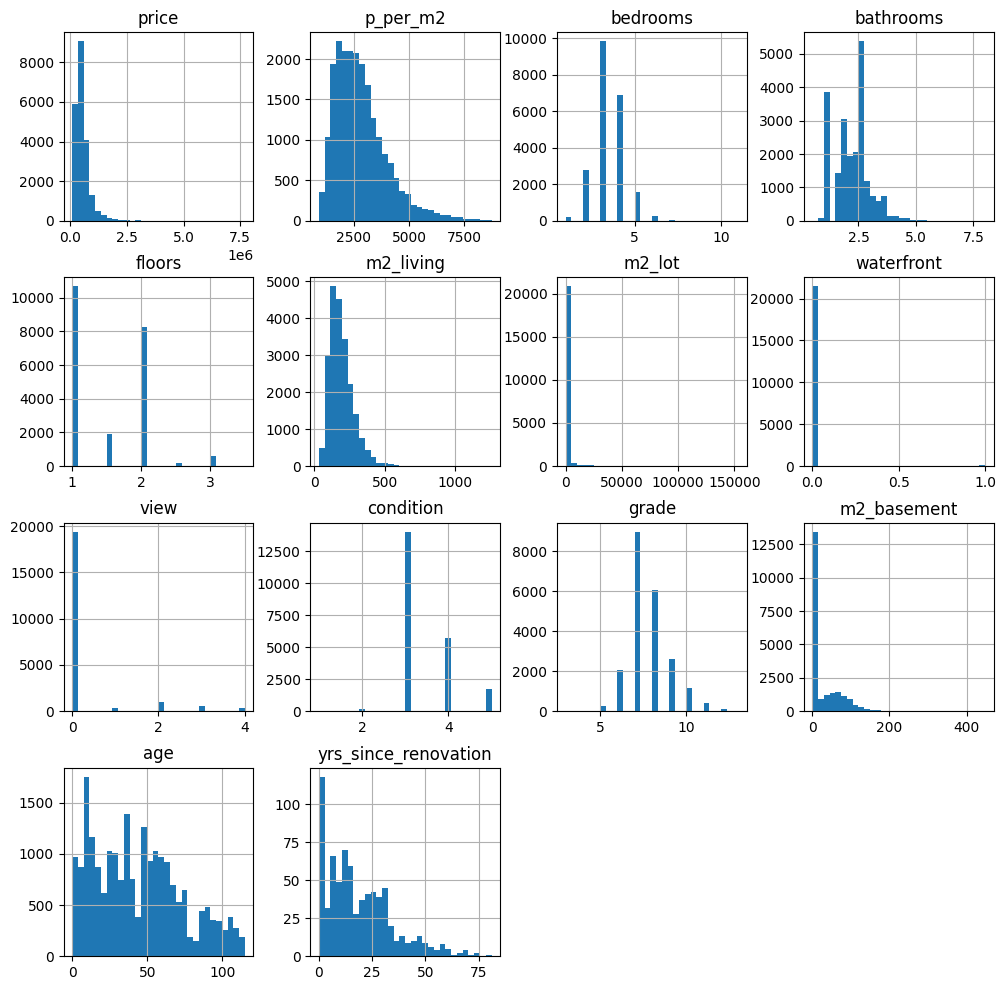

In [17]:
# No geodata: we will plot it on a map
df.hist(column=['price', 'p_per_m2', 'bedrooms', 'bathrooms', 'floors', 'm2_living', 'm2_lot', 
       'waterfront', 'view', 'condition', 'grade', 'm2_basement',
       'age', 'yrs_since_renovation'],
       figsize=(12, 12), bins=30);

* The `price`distribution is very skewed: there are very few very expensive properties. 
    * The median selling `price` is about **$0.5 M**
* There are only a few houses in the `condition`below "average" ($3$)
* The `lot` size distribution is even more skewed: there are single enormou(s) lot(s); the largest `lot` is huge, it is $153000$ $m^2$! Is it a farm or a manson?
* The `view` grade ranges from 0 to 4 with the absolute majority of the houses rated as 0
* The overall house `grade` is symmetrically distributed and in the current sample ranges from $3$ (a barely livable cabin) to $13$ (a manson) with the median of $7$ (*average* quality) 


Let's look at the disstribution of the most prominent feature, the `price`:

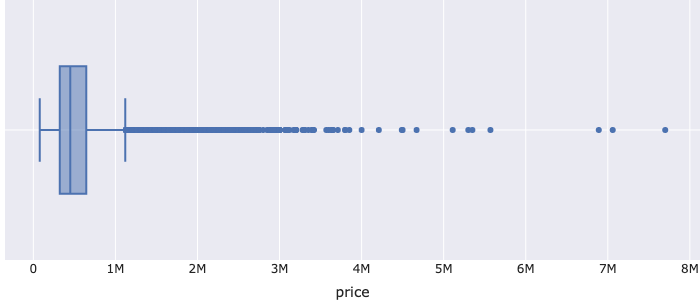

In [18]:
fig = px.box(df, x='price', height=300, template='seaborn')
fig.update_layout(margin={'l':0, 't':0, 'r':0, 'b': 30})
fig.show()

Following our *presumption* that the Client is *not* interested in the luxorious properties, it is totally safe to discard the houses that form the right tail of the price distribution: anything above the Q3 + 1.5 IQR (the right whisker of the box plot)

In [19]:
dfp = df[df.price < 1.12e6]

In [20]:
dfp.drop('id',axis=1).describe().style.format(precision=1) 

,bedrooms,bathrooms,m2_living,m2_lot,floors,waterfront,view,condition,grade,m2_above,m2_basement,yr_built,yr_renovated,zipcode,lat,long,m2_living15,m2_lot15,price,basement_share,age,yrs_since_renovation,p_per_m2
count,20426.0,20426.0,20426.0,20426.0,20426.0,20426.0,20368.0,20426.0,20426.0,20426.0,20426.0,20426.0,624.0,20426.0,20426.0,20426.0,20426.0,20426.0,20426.0,20426.0,20426.0,624.0,20426.0
mean,3.3,2.1,183.4,1354.7,1.5,0.0,0.2,3.4,7.5,158.6,24.8,1970.8,1995.5,98078.6,47.6,-122.2,178.5,1154.4,476316.7,0.1,44.2,19.5,2737.0
std,0.9,0.7,71.8,3717.9,0.5,0.0,0.6,0.6,1.0,67.5,37.9,29.2,16.2,53.3,0.1,0.1,57.0,2459.7,207267.2,0.2,29.2,16.2,1078.8
min,1.0,0.5,34.4,48.3,1.0,0.0,0.0,1.0,3.0,34.4,0.0,1900.0,1934.0,98001.0,47.2,-122.5,37.1,60.5,78000.0,0.0,0.0,0.0,942.8
25%,3.0,1.5,130.1,464.5,1.0,0.0,0.0,3.0,7.0,108.7,0.0,1951.0,1986.0,98033.0,47.5,-122.3,136.6,468.8,315000.0,0.0,19.0,7.0,1926.7
50%,3.0,2.0,172.1,696.8,1.0,0.0,0.0,3.0,7.0,141.2,0.0,1974.0,1999.0,98065.0,47.6,-122.2,167.2,700.5,437000.0,0.0,41.0,16.0,2562.9
75%,4.0,2.5,225.8,957.4,2.0,0.0,0.0,4.0,8.0,195.1,47.4,1996.0,2008.0,98118.0,47.7,-122.1,211.8,917.7,600000.0,0.3,64.0,29.0,3289.0
max,11.0,7.5,694.9,153415.0,3.5,1.0,4.0,5.0,12.0,530.5,252.7,2015.0,2015.0,98199.0,47.8,-121.3,499.8,80936.5,1110000.0,0.7,115.0,81.0,8720.3


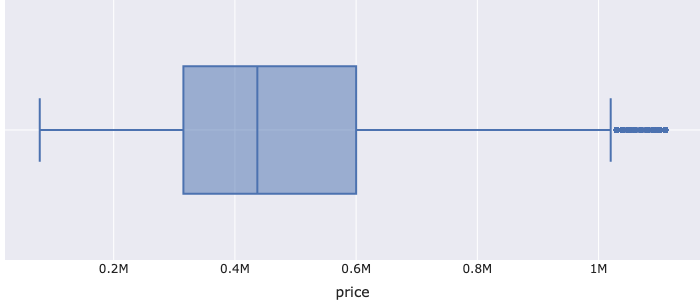

In [21]:
fig = px.box(dfp, x='price', height=300, template='seaborn')
fig.update_layout(margin={'l':0, 't':0, 'r':0, 'b': 30})
fig.show()

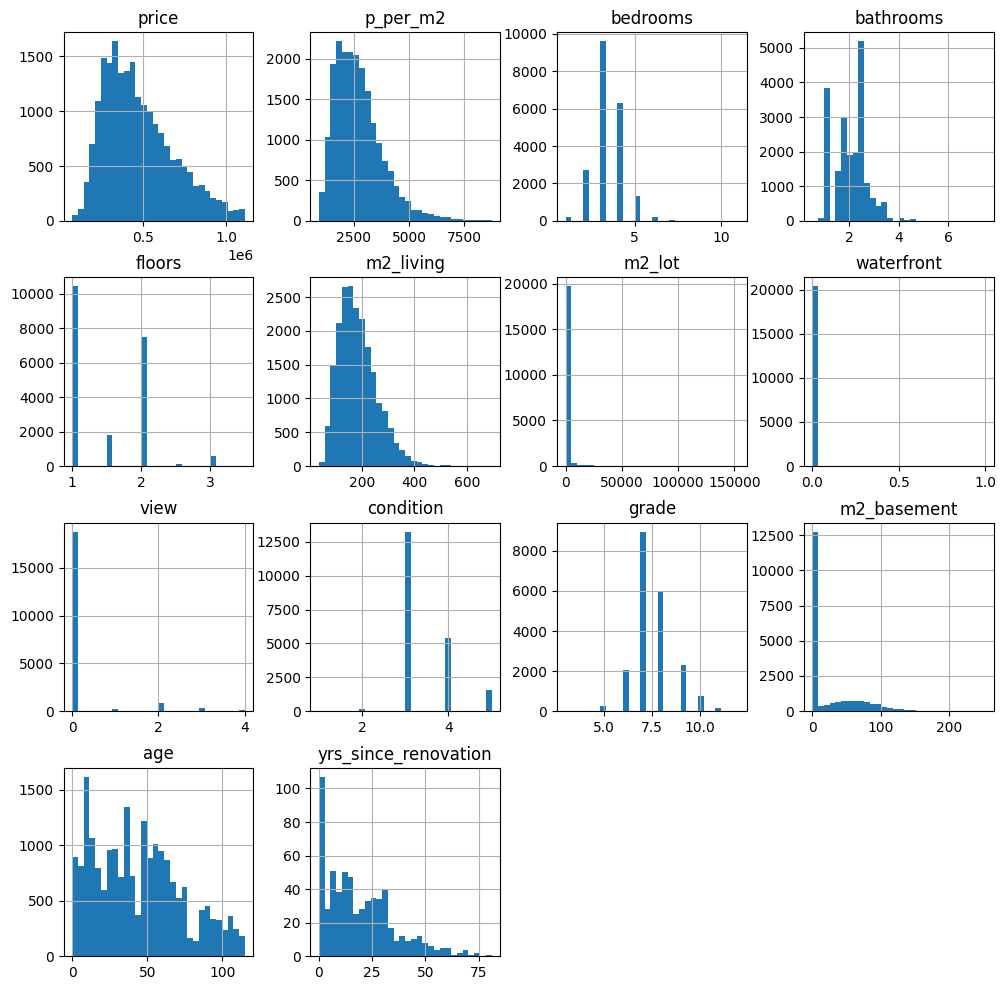

In [22]:
dfp.hist(column=['price', 'p_per_m2', 'bedrooms', 'bathrooms', 
                 'floors', 'm2_living', 'm2_lot', 'waterfront', 
                 'view', 'condition', 'grade', 'm2_basement',
                 'age', 'yrs_since_renovation'],
       figsize=(12, 12), bins=30);

Much better!
* The huge lot stayed: this is probably a farm
* Even fewer houses beside the water left. 
* We still have large houses with > 5 bedrooms and / or > 5 bathrooms!

### Creating the checkpoint by saving the imputed dataset 

In [23]:
dfp.to_csv('data/houses_processed.csv', index=False)